In [5]:
from datetime import datetime, timezone, timedelta
from collections import defaultdict
from time import time
import json
import os
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tweepy

In [6]:
#inputs
bearer_token = "AAAAAAAAAAAAAAAAAAAAAH4BlAEAAAAA3Dd4SGtdK%2FWbAqlEdIcXzoPB4%2BA%3DwDjEbymhTQgnmvHM8Vvetae79bgdBz1eyHWSyXZVqRnCCir1nA" #mpolo
limit = 100 #number of requests of `max_results` tweets each

TODO: `search_recent_tweets` is up to 7 days. To search further back, use [search_all_tweets](https://docs.tweepy.org/en/stable/client.html#tweepy.Client.search_all_tweets) instead (and add `start_time` parameter). But it needs the [academic research access](https://developer.twitter.com/en/docs/projects). It also increases the monthly cap from 500,000 to 10 million, `max_results` from 100 to 500, and allows to use `-is:nullcast ` to filter out some ads.

In [7]:
#create paginator
client = tweepy.Client(bearer_token)
paginator = tweepy.Paginator(
    method = client.search_recent_tweets,
    limit = limit,
    query = (
        '(context:131.825047692124442624 OR context:152.825047692124442624) ' #https://github.com/twitterdev/twitter-context-annotations
        '-is:retweet ' #only original tweets
        '-is:reply '
        '-is:quote '
        '-has:links ' #no tweets with embedded images etc.
        '-has:media '
        'lang:en'),
    end_time = (datetime.now(timezone.utc)-timedelta(days=6)).isoformat(), #go backwards from 6 days ago
    expansions = ['author_id'], #TODO search doc for other usefull expansions
    max_results = 100,
    tweet_fields = ['public_metrics'], #TODO search doc for other usefull tweet fields
    user_fields = ['public_metrics']) #TODO search doc for other usefull user fields

#download tweets
data = defaultdict(list)
for response in paginator:
    for tweet, user in zip(response.data, response.includes['users']):
        if tweet.author_id == user.id: #some don't match for no reason
            data['text'] += [tweet.text]
            data['likes'] += [tweet.public_metrics['like_count']]
            data['followers'] += [user.public_metrics['followers_count']]

#save tweets
dir_ = f'debug_sets/{int(time() % 1e6)}/' #unique for 11 days
os.makedirs(dir_)
pd.DataFrame(data).to_csv(dir_+'dataset.csv', index=False)
with open(dir_+'metadata.json', mode='w') as fp:
    json.dump(paginator.kwargs, fp)
dir_

'debug_sets/614548/'

In [8]:
#load tweets
df = pd.read_csv(dir_+'dataset.csv')
df['likes'] += 1 #start likes from 1 for simplicity
df['followers'] += 1 #start followers from 1 for simplicity
df.head(2)

,text,likes,followers
0,Hope you're all having a lovely Saturday. Weat...,2,453
1,Just a great lunch #girltalk #nokids \nBut now...,4,128


array([0.27887464])

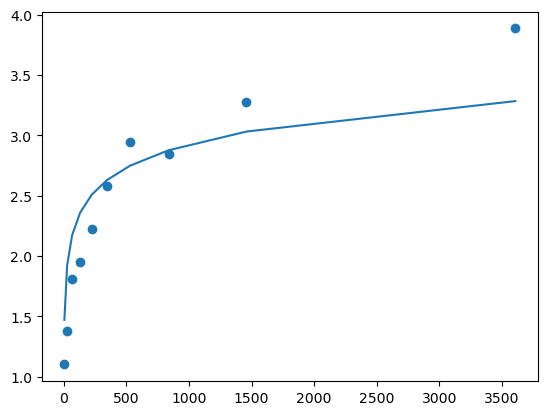

In [18]:
#remove outliers TODO tune q (eg.: 0.95)
q = df.quantile(0.95, numeric_only=True) #numeric_only to fix warning
df_q = df[(df['likes'] < q['likes']) & (df['followers'] < q['followers'])].copy() #copy to fix warning

#group by followers TODO tune number of groups (eg.: 10)
df_q.sort_values(by='followers', inplace=True, ignore_index=True)
df_q['group'] = df_q.index//(len(df_q)/10) #groups of same size
df_q = df_q.groupby('group').mean(numeric_only=True) #numeric_only to fix warning

#plot average followers vs average likes
x = df_q['followers']
y = df_q['likes']
plt.scatter(x, y)

#fit log curve and plot it TODO add linear component (eg.: 1 + a*x + b*np.log(x))?
def curve(x, coeff):
    return 1 + coeff * np.log(x) #not log1p for simplicity
coeff, _ = curve_fit(curve, xdata=x, ydata=y)
plt.plot(x, curve(x, coeff))
coeff

In [19]:
#get popularity by normalizing likes
df['popularity'] = df['likes']/curve(df['followers'], coeff)

#assign popularity level
df.sort_values(by='popularity', inplace=True, ignore_index=True)
df['pop_level'] = df.index//(len(df)/3) #groups of same size
df

,text,likes,followers,popularity,pop_level
0,Friday lunch #VerdeTruck \n11AM-230PM\n#DTLA\n...,1,146614,0.231623,0.0
1,"All the food used to be ""organic"" before eugen...",1,78226,0.241419,0.0
2,Industrial hemp products can provide a number ...,1,74462,0.242223,0.0
3,How much land is needed for a &gt; ^Hemp - far...,1,74462,0.242223,0.0
4,"&gt; ^Hemp - crops are tall, have thick foliag...",1,74462,0.242223,0.0
...,...,...,...,...,...
7391,Went into town for my 54th birthday lunch &amp...,1850,25396,483.225123,2.0
7392,"Started my diet last week, I’ve got to get som...",1971,25549,514.605503,2.0
7393,Tip for law students: when a former public off...,1964,7022,566.004378,2.0
7394,did anyone else notice that in Supersize vs. S...,2797,28769,724.007270,2.0


TODO imo vedi grafico sopra (quello dove fitti il log) e vedi a quanti follower ci si aspetta almeno un like (2 visto che uno lo hai regalato). Elimina tutti i tweet con zero like  (1 visto che...) e meno follower perché non danno informazioni.
Cioè se ha pochissimi follower e cmq 2 like allora sai che buono, ma se ha 1 like e boh tipo 20 follower non puoi dire che il tweet fa schifo visto che non ci si aspetta più like comunque. Cioè son praticamente delle osservazioni senza label e quindi vanno tolte. Pensa anche a 1 like e 1 follower (entrambi regalati), viene popularity 1 cioé nella media ma in verità non si può giudicare. O forse boh van bene lo stesso perché spostano gli altri (cioé fanno scalare di classe quelli con stesso numero di like e più follower, che ci sta). pensaci. intanto lasciali per semplicità

In [21]:
df[['text', 'pop_level']].to_csv('debug_set_614548.csv', index=False)

In [22]:
df = pd.read_csv('debug_set_614548.csv')
df

,text,pop_level
0,Friday lunch #VerdeTruck \n11AM-230PM\n#DTLA\n...,0.0
1,"All the food used to be ""organic"" before eugen...",0.0
2,Industrial hemp products can provide a number ...,0.0
3,How much land is needed for a &gt; ^Hemp - far...,0.0
4,"&gt; ^Hemp - crops are tall, have thick foliag...",0.0
...,...,...
7391,Went into town for my 54th birthday lunch &amp...,2.0
7392,"Started my diet last week, I’ve got to get som...",2.0
7393,Tip for law students: when a former public off...,2.0
7394,did anyone else notice that in Supersize vs. S...,2.0
